In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cmaps
import cnmaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

import rioxarray
import rasterio
from rasterio.plot import show
import geopandas
import pyhomogeneity as hg
from shapely.geometry import mapping

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

In [3]:
fwi_1980_2022 = xr.open_dataset('/Volumes/Seagate_HZQ/reanalyses/FWI_merra2/FWI.MERRA2.Daily.Default_CN.1980-2022.nc')
doy_idx = [i for i in range(92)] * 43
fwi_1980_2022.coords['doy'] = ('time', doy_idx)
fwi_1980_2011_clim = fwi_1980_2022.sel(time=slice('1980','2010')).groupby('doy').mean(skipna=True)
fwi_1980_2022_ano = fwi_1980_2022.groupby('doy') - fwi_1980_2011_clim

In [4]:
# extract fwi data covering chongqing (anomalies)
fwi_1980_2022_ano_fireloc = fwi_1980_2022_ano.sel(lon=slice(105,107),lat=slice(29,31)) #lon=slice(104.5,107.5),lat=slice(28.5,31.5)
weights = np.cos(np.deg2rad(fwi_1980_2022_ano_fireloc.lat))
weights.name = 'weights'
fwi_1980_2022_ano_fireloc_weighted = fwi_1980_2022_ano_fireloc.weighted(weights)
fwi_1980_2022_ano_fireloc_ts = fwi_1980_2022_ano_fireloc_weighted.mean(('lon','lat'))

fwi_1980_2022_ano_fireloc_ts_mean = fwi_1980_2022_ano_fireloc_ts.groupby('doy').mean()
fwi_1980_2022_ano_fireloc_ts_std = fwi_1980_2022_ano_fireloc_ts.groupby('doy').std()
fwi_1980_2022_ano_fireloc_ts_up = fwi_1980_2022_ano_fireloc_ts_mean + fwi_1980_2022_ano_fireloc_ts_std
fwi_1980_2022_ano_fireloc_ts_down = fwi_1980_2022_ano_fireloc_ts_mean - fwi_1980_2022_ano_fireloc_ts_std

In [5]:
# extract fwi data covering chongqing (absolute)
fwi_1980_2022_fireloc = fwi_1980_2022.sel(lon=slice(105,107),lat=slice(29,31))
weights = np.cos(np.deg2rad(fwi_1980_2022_fireloc.lat))
weights.name = 'weights'
fwi_1980_2022_fireloc_weighted = fwi_1980_2022_fireloc.weighted(weights)
fwi_1980_2022_fireloc_ts = fwi_1980_2022_fireloc_weighted.mean(('lon','lat'))

fwi_1980_2022_fireloc_ts_mean = fwi_1980_2022_fireloc_ts.groupby('doy').mean()
fwi_1980_2022_fireloc_ts_std = fwi_1980_2022_fireloc_ts.groupby('doy').std()
fwi_1980_2022_fireloc_ts_up = fwi_1980_2022_fireloc_ts_mean + fwi_1980_2022_fireloc_ts_std
fwi_1980_2022_fireloc_ts_down = fwi_1980_2022_fireloc_ts_mean - fwi_1980_2022_fireloc_ts_std

In [6]:
# extract t2m data for chongqing

reanalysis_dir = '/Volumes/Seagate_HZQ/reanalyses/'

for i in range(1979,2023):
    t2m_daily_i = xr.open_dataarray(reanalysis_dir + 'era5/' + '2m_temperature_daily_era5_' + str(i) + '.nc')
    t2m_daily_i = t2m_daily_i.sel(latitude = slice(54,17),longitude = slice(72,136))
    if i == 1979:
        t2m_daily_all = t2m_daily_i
    else:
        t2m_daily_i = t2m_daily_i
        t2m_daily_all = xr.concat([t2m_daily_all,t2m_daily_i], dim='time')

# calculate JJA daily SAT mean
# day-of-year of JJA ranges from 152-243
# note that groupby_bins are open in the left and close in the right
for i in range(152, 244):
    freeze_bins = [i-3,i+2]
    t2m_daily_all_1979_2010 = t2m_daily_all.sel(time=slice('1979-01-01','2010-12-31'))
    t2m_daily_mean_1979_2010_i = t2m_daily_all_1979_2010.groupby_bins('time.dayofyear',freeze_bins).mean(dim='time')
    if i == 152:
        t2m_daily_mean_1979_2010 = t2m_daily_mean_1979_2010_i
    else:
        t2m_daily_mean_1979_2010 = xr.concat([t2m_daily_mean_1979_2010, t2m_daily_mean_1979_2010_i],dim='dayofyear_bins')

##  2022 t2m anomalies for chongqing
JJA = t2m_daily_all.time.dt.month.isin(range(6,9))
t2m_daily_summer = t2m_daily_all.sel(time=JJA)

t2m_daily_summer_2022 = t2m_daily_summer.sel(time=slice('2022-06-01','2022-08-31'))
t2m_daily_mean_1979_2010_copy = t2m_daily_mean_1979_2010.rename({'dayofyear_bins':'time'})
t2m_daily_mean_1979_2010_copy['time'] = t2m_daily_summer_2022.time
t2m_daily_summer_2022_ano = t2m_daily_summer_2022 - t2m_daily_mean_1979_2010_copy
t2m_daily_summer_2022_ano_chongqing = t2m_daily_summer_2022_ano.sel(latitude = slice(31,29),longitude = slice(105,107))

weights = np.cos(np.deg2rad(t2m_daily_summer_2022_ano_chongqing.latitude))
weights.name = 'weights'
t2m_daily_summer_2022_ano_chongqing_weighted = t2m_daily_summer_2022_ano_chongqing.weighted(weights)
t2m_2022_ano_chongqing_ts = t2m_daily_summer_2022_ano_chongqing_weighted.mean(('longitude','latitude'))

In [7]:
# extract vpd for chongqing 
# calculate vpd https://earthscience.stackexchange.com/questions/24156/era5-single-level-calculate-relative-humidity, https://physics.stackexchange.com/questions/4343/how-can-i-calculate-vapor-pressure-deficit-from-temperature-and-relative-humidit
def cal_vpd_from_t2m_d2m(t2m,d2m):
    es = 0.61078 * np.exp((17.27*(t2m-273.15))/(t2m-273.15+237.3)) # kpa
    e  = 0.61078 * np.exp((17.27*(d2m-273.15))/(d2m-273.15+237.3)) # kpa
    RH = e/es * 100
    vpd = es * (100 - RH) / 100
    return vpd # kPa

t2m_d2m_chongqing = xr.open_dataset('data/era5_t2m_dew2m_chongqing.nc')
d2m_6hourly = t2m_d2m_chongqing['d2m']
t2m_6hourly = t2m_d2m_chongqing['t2m']
vpd_6hourly = xr.apply_ufunc(
    cal_vpd_from_t2m_d2m, t2m_6hourly, d2m_6hourly,
    )
vpd_daily = vpd_6hourly.resample(time='1D').mean('time')

# calculate JJA daily SAT mean
# day-of-year of JJA ranges from 152-243
# note that groupby_bins are open in the left and close in the right
for i in range(152, 244):
    freeze_bins = [i-3,i+2]
    vpd_daily_all_1979_2010 = vpd_daily.sel(time=slice('1979-01-01','2010-12-31'))
    vpd_daily_all_1979_2010_i = vpd_daily_all_1979_2010.groupby_bins('time.dayofyear',freeze_bins).mean(dim='time')
    if i == 152:
        vpd_daily_mean_1979_2010 = vpd_daily_all_1979_2010_i
    else:
        vpd_daily_mean_1979_2010 = xr.concat([vpd_daily_mean_1979_2010, vpd_daily_all_1979_2010_i],dim='dayofyear_bins')

##  2022 vpd anomalies for chongqing
vpd_daily_summer_2022 = vpd_daily.sel(time=slice('2022-06-01','2022-08-31'))
vpd_daily_mean_1979_2010_copy = vpd_daily_mean_1979_2010.rename({'dayofyear_bins':'time'})
vpd_daily_mean_1979_2010_copy['time'] = vpd_daily_summer_2022.time
vpd_daily_summer_2022_ano = vpd_daily_summer_2022 - vpd_daily_mean_1979_2010_copy
vpd_daily_summer_2022_ano_chongqing = vpd_daily_summer_2022_ano.sel(latitude = slice(31,29),longitude = slice(105,107))

weights = np.cos(np.deg2rad(vpd_daily_summer_2022_ano_chongqing.latitude))
weights.name = 'weights'
vpd_daily_summer_2022_ano_chongqing_weighted = vpd_daily_summer_2022_ano_chongqing.weighted(weights)
vpd_2022_ano_chongqing_ts = vpd_daily_summer_2022_ano_chongqing_weighted.mean(('longitude','latitude'))


In [8]:
fwi_1980_2022_ano_fireloc_ts_i = fwi_1980_2022_ano_fireloc_ts.sel(time = fwi_1980_2022_ano_fireloc_ts.time.dt.year==2022)
fwi_2022 = fwi_1980_2022_ano_fireloc_ts_i['MERRA2_FWI']
print(np.corrcoef([vpd_2022_ano_chongqing_ts,t2m_2022_ano_chongqing_ts]))
print(np.corrcoef([vpd_2022_ano_chongqing_ts,fwi_2022]))
print(np.corrcoef([t2m_2022_ano_chongqing_ts,fwi_2022]))

[[1.         0.93725296]
 [0.93725296 1.        ]]
[[1.        0.9138612]
 [0.9138612 1.       ]]
[[1.         0.87027336]
 [0.87027336 1.        ]]


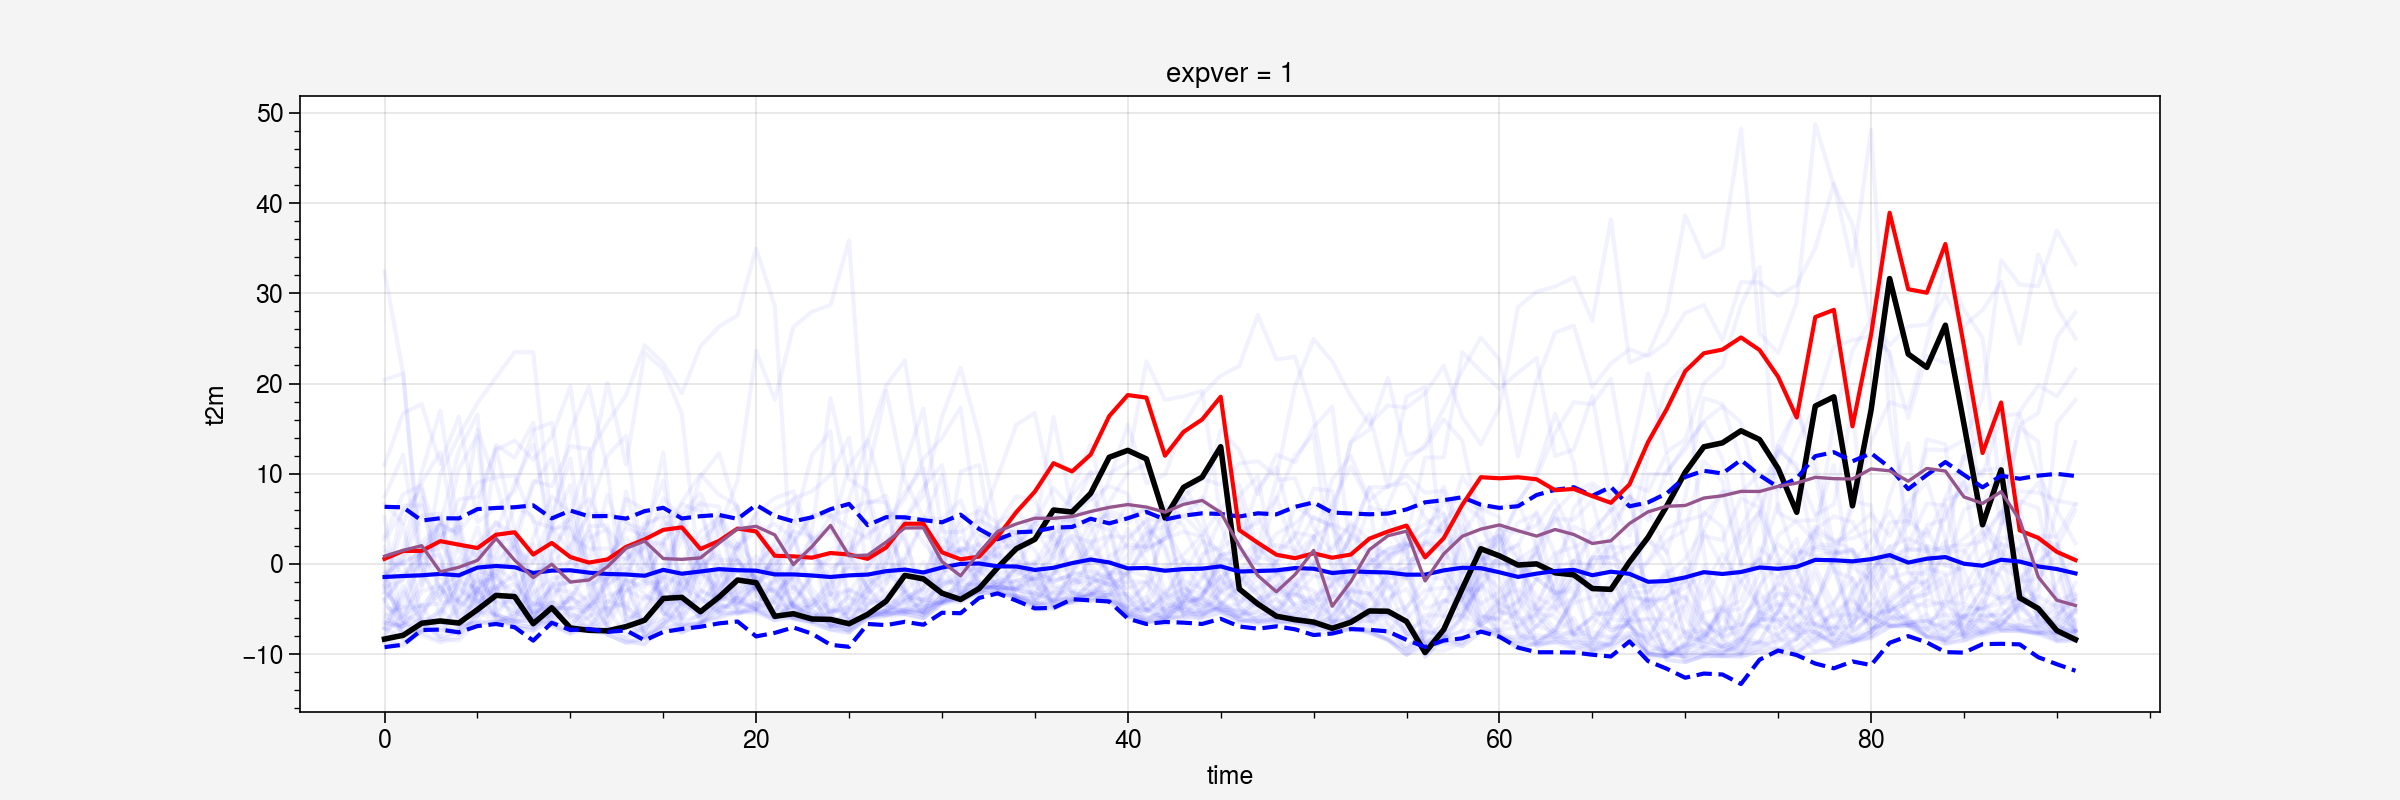

In [9]:
fig = plt.figure(figsize = (12,4))
for i in range(1980,2023):
    fwi_1980_2022_ano_fireloc_ts_i = fwi_1980_2022_ano_fireloc_ts.sel(time = fwi_1980_2022_ano_fireloc_ts.time.dt.year==i)
    fwi_i = fwi_1980_2022_ano_fireloc_ts_i['MERRA2_FWI']
    fwi_i['time'] = range(92)
    if i == 2022:
        fwi_i.plot(lw=2,c='black')
    else:
        fwi_i.plot(c='blue',alpha=0.05)

fwi_1980_2022_ano_fireloc_ts_mean['MERRA2_FWI'].plot(lw=1.5,c='blue')
fwi_1980_2022_ano_fireloc_ts_up['MERRA2_FWI'].plot(lw=1.5,c='blue',ls='--')
fwi_1980_2022_ano_fireloc_ts_down['MERRA2_FWI'].plot(lw=1.5,c='blue',ls='--')

fwi_2022_fireloc_ts_abs = fwi_1980_2022_fireloc_ts['MERRA2_FWI'][-92:]
fwi_2022_fireloc_ts_abs['time'] = range(92)
fwi_2022_fireloc_ts_abs.plot(lw=1.5,c='red')

t2m_2022_ano_chongqing_ts['time'] = range(92)
t2m_2022_ano_chongqing_ts.plot(lw=1.2,c='purple')

In [14]:
from descartes import PolygonPatch
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

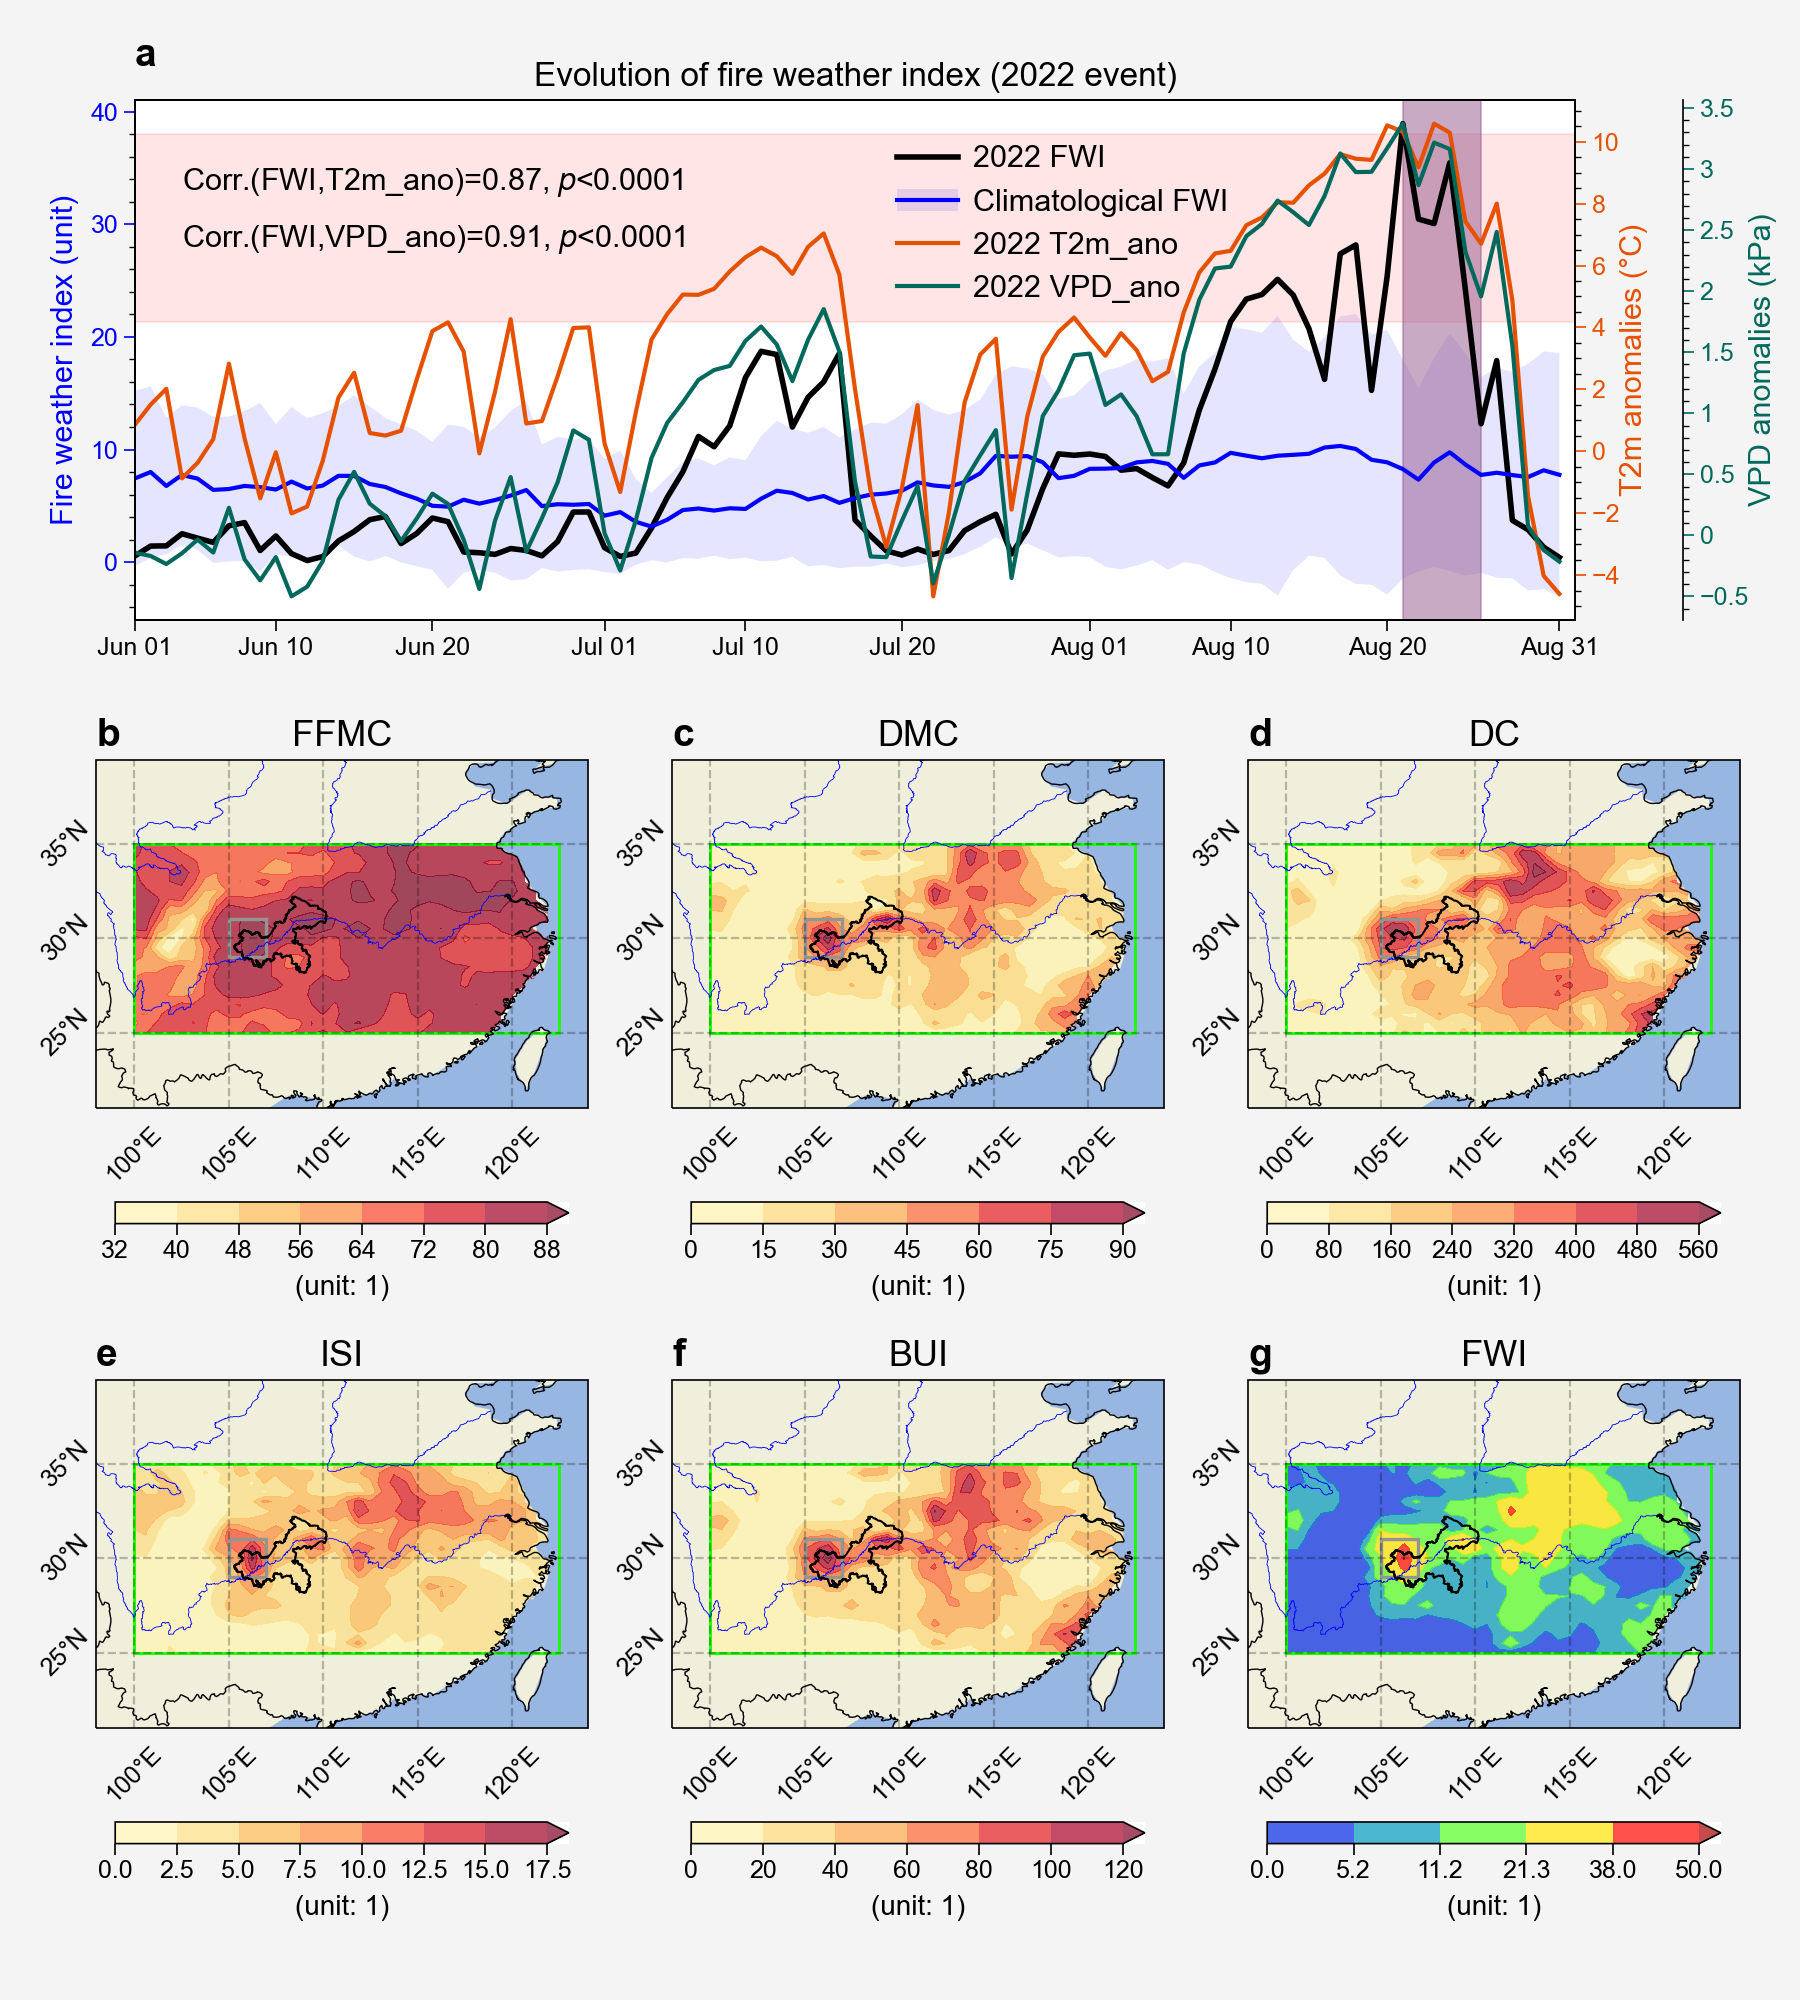

In [15]:
from matplotlib.patches import Rectangle
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
chongqing = shpreader.Reader('shapefiles/chongqing.shp')
chongqing_feature = ShapelyFeature(chongqing.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.7)
import matplotlib.ticker as mticker
import matplotlib as mpl
from copy import copy
plt.rcParams["font.family"] = "Arial"

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

axes_locs = [
    [0.075,0.69,0.8,0.26],
    [0.05,0.36,0.28,0.26],
    [0.37,0.36,0.28,0.26],
    [0.69,0.36,0.28,0.26],
    [0.05,0.05,0.28,0.26],
    [0.37,0.05,0.28,0.26],
    [0.69,0.05,0.28,0.26],
]

fig = plt.figure(figsize = (9,10))

# ax1 for temporal evolution of fwi
ax1 = fig.add_axes(axes_locs[0])
for i in range(1980,2023):
    fwi_1980_2022_fireloc_ts_i = fwi_1980_2022_fireloc_ts.sel(time = fwi_1980_2022_ano_fireloc_ts.time.dt.year==i)
    fwi_i = fwi_1980_2022_fireloc_ts_i['MERRA2_FWI']
    fwi_i['time'] = range(92)
    if i == 2022:
        p0 = ax1.plot(range(92),fwi_i,lw=2,c='black')
    else:
        continue
        ax1.plot(range(92),fwi_i,c='blue',alpha=0.05)

p1 = ax1.plot(range(92),fwi_1980_2022_fireloc_ts_mean['MERRA2_FWI'],c='blue',lw=1.5)
y2 = fwi_1980_2022_fireloc_ts_down['MERRA2_FWI']
y1 = fwi_1980_2022_fireloc_ts_up['MERRA2_FWI']
fb = ax1.fill_between(range(92), y1, y2, where=y2 <= y1, facecolor='blue', alpha=0.1, interpolate=True)
ax1.axhspan(21.3, 38.0, alpha=0.1, color='red')

twin1 = ax1.twinx()
twin2 = ax1.twinx()
# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.075))

p2 = twin1.plot(range(92),t2m_2022_ano_chongqing_ts,c='#E65100',lw=1.5)
p3 = twin2.plot(range(92),vpd_2022_ano_chongqing_ts,c='#00695C',lw=1.5)

ax1.set_xticks([0,9,19,30,39,49,61,70,80,91])
ax1.set_xticklabels(['Jun 01','Jun 10','Jun 20','Jul 01','Jul 10','Jul 20','Aug 01','Aug 10','Aug 20','Aug 31'])
ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.set_xlim((0,92))
ax1.grid(False)
ax1.set_ylabel('Fire weather index (unit)',fontdict={'fontsize':11})
twin1.set_ylabel('T2m anomalies (°C)',fontdict={'fontsize':11},labelpad=0)
twin2.set_ylabel('VPD anomalies (kPa)',fontdict={'fontsize':11},labelpad=0)
twin1.grid(False)
twin2.grid(False)

ax1.yaxis.label.set_color('blue')
twin1.yaxis.label.set_color('#E65100')
twin2.yaxis.label.set_color('#00695C')
ax1.tick_params(axis='y', colors='blue')
twin1.tick_params(axis='y', colors='#E65100')
twin2.tick_params(axis='y', colors='#00695C')

ax1.axvspan(81, 86, alpha=0.5, color='purple')
ax1.text(x=3,y=33,s='Corr.(FWI,T2m_ano)='+str(round(np.corrcoef([t2m_2022_ano_chongqing_ts,fwi_2022])[1,0],2))+', $\it{p}$<0.0001',fontsize=11)
ax1.text(x=3,y=28,s='Corr.(FWI,VPD_ano)='+str(round(np.corrcoef([vpd_2022_ano_chongqing_ts,fwi_2022])[1,0],2))+', $\it{p}$<0.0001',fontsize=11)
ax1.set_title('Evolution of fire weather index (2022 event)',fontdict={'fontsize':12,'fontweight': 'medium'},y=1)
ax1.legend(
    [p0[0],(p1[0],fb),p2[0],p3[0]], ['2022 FWI','Climatological FWI','2022 T2m_ano','2022 VPD_ano'],fancybox = True,frameon=False, bbox_to_anchor=[0.77,0.58],
    ncol=1,fontsize=11)

add_panel_label(ax1, 'a', x=0, y = 1.12)

# ax3-ax8 for spatial distribution of fire weather index
mapcrs = ccrs.PlateCarree()
fwi_components = ['MERRA2_FFMC','MERRA2_DMC','MERRA2_DC','MERRA2_ISI','MERRA2_BUI','MERRA2_FWI']
titles = ['FFMC','DMC','DC','ISI','BUI','FWI']
for i in range(6):
	ax = fig.add_axes(axes_locs[1+i],projection=mapcrs)
	clip_copy = copy(clip)
	ax.add_patch(clip_copy)
	ax.add_feature(cfeature.LAND.with_scale('110m'))
	ax.add_feature(cfeature.OCEAN.with_scale('110m'))
	ax.add_feature(river_feature)
	ax.add_feature(chongqing_feature)
	ax.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
	ax.add_patch(Rectangle((105,29),width=2,height=2,fc='none',color='grey',linewidth=1.2,)) #Rectangle((104.5,28.5),width=3,height=3,fc='none',color='#16FF00',linewidth=1,)
	china = get_map('中国')
	draw_map(china,color='black',linewidth=0.5)
	fwi_c = fwi_components[i]
	fwi_1980_2022_YRB = fwi_1980_2022[fwi_c].sel(lat = slice(25,35),lon = slice(100,122.5))
	fwi_2022fire_YRB = fwi_1980_2022_YRB.sel(time=slice('2022-08-21','2022-08-26')).mean(dim='time')
	lon = fwi_2022fire_YRB['lon']
	lat = fwi_2022fire_YRB['lat']
	if fwi_c != 'MERRA2_FWI':
		p3 = ax.contourf(lon, lat, fwi_2022fire_YRB, cmap=cmaps.MPL_YlOrRd, extend = 'max', transform=ccrs.PlateCarree(),alpha=0.7) #levels=[0,10,20,30,40,50],
	else:
		p3 = ax.contourf(lon, lat, fwi_2022fire_YRB, cmap=cmaps.GMT_seis_r, extend = 'max',levels=[0,5.2,11.2,21.3,38,50], transform=ccrs.PlateCarree(),alpha=0.7) #
	for c in p3.collections:
		c.set_clip_path(clip_copy)
		c.set_rasterized(True)
    
	ax.set_title(titles[i],fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
	fig_cbar = fig.colorbar(p3, ax=ax, location='bottom', shrink = 0.9, extend = 'max', pad=0.18)
	fig_cbar.ax.tick_params(labelsize=9)
	fig_cbar.set_label('(unit: 1)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
	fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

	gl1 = ax.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
	ax.set_extent([98, 124, 21, 39])

	gl1.ylocator = mticker.FixedLocator([25,30,35])
	gl1.xformatter = LONGITUDE_FORMATTER
	gl1.yformatter = LATITUDE_FORMATTER
	gl1.xlabel_style = {'rotation': 45, 'ha':'center','size':9}
	gl1.ylabel_style = {'rotation': 45, 'ha':'center','size':9}
	gl1.right_labels = False
	gl1.top_labels = False
	add_panel_label(ax, 'bcdefg'[i], x=0, y = 1.12)

plt.tight_layout()
plt.savefig("Figures/Fig2_FWI.pdf")
fig.savefig('Figures/Fig2_FWI.png')
